<a href="https://colab.research.google.com/github/yuvalira/Adversarial-Attacks-Article/blob/main/models/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classical Model — XGBoost**
XGBoost is a highly optimized implementation of gradient-boosted decision trees.
It typically delivers **state-of-the-art performance on tabular data** thanks to:
- Shrinkage (**learning rate**) and **regularization** (L1/L2)
- Column & row subsampling that reduce overfitting
- Efficient tree growth (`hist`/`approx`)

We'll fit on **train**, evaluate on **validation** (test remains reserved for attacks).

References:
- [xgboost.XGBClassifier docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

## Imports & setup

In [9]:
!pip -q install -U scikit-learn xgboost huggingface_hub

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load splits from HF

In [10]:
repo_id   = "yuvalira/adult_income_balanced"  # TODO
repo_type = "dataset"

def read_split_csv(repo_id, filename, repo_type="dataset"):
    p = hf_hub_download(repo_id=repo_id, filename=filename, repo_type=repo_type, token=False)
    return pd.read_csv(p)

train_data = read_split_csv(repo_id, "train.csv", repo_type)
val_data   = read_split_csv(repo_id, "val.csv",   repo_type)

print("Train:", train_data.shape, "| Val:", val_data.shape)

Train: (11687, 14) | Val: (2337, 14)


## Discover column types & configure target

In [11]:
auto_num = train_data.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
auto_cat = train_data.select_dtypes(include=['object','category','bool']).columns.tolist()

TARGET_COLUMN_NAME = "income"              # TODO
TARGET_LABELS = ["<=50K", ">50K"]          # TODO (order defines ids)
SAMPLE_WEIGHT_COLUMN = None                # or "weight"

NUMERIC_FEATURE_NAMES = [c for c in auto_num if c != TARGET_COLUMN_NAME]
CATEGORICAL_FEATURE_NAMES = [c for c in auto_cat if c != TARGET_COLUMN_NAME]

print("Numeric features:", NUMERIC_FEATURE_NAMES)
print("Categorical features:", CATEGORICAL_FEATURE_NAMES)

Numeric features: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


## Prepare dataframes (map target, cast categoricals to str)

In [12]:
train_data = train_data.copy()
val_data   = val_data.copy()

label2id = {lbl:i for i,lbl in enumerate(TARGET_LABELS)}
id2label = {i:lbl for lbl,i in label2id.items()}

def prepare_df(df):
    assert TARGET_COLUMN_NAME in df.columns, f"No target '{TARGET_COLUMN_NAME}'"
    df[TARGET_COLUMN_NAME] = df[TARGET_COLUMN_NAME].map(label2id)
    if df[TARGET_COLUMN_NAME].isna().any():
        bad = df.loc[df[TARGET_COLUMN_NAME].isna(), TARGET_COLUMN_NAME].unique().tolist()
        raise ValueError(f"Unmapped targets: {bad} vs {TARGET_LABELS}")
    for c in CATEGORICAL_FEATURE_NAMES:
        if c in df.columns:
            df[c] = df[c].astype(str)
    return df

prepare_df(train_data); prepare_df(val_data)
n_classes = int(train_data[TARGET_COLUMN_NAME].nunique())
avg_mode = None if n_classes==2 else "macro"
print("Classes:", [id2label[i] for i in sorted(train_data[TARGET_COLUMN_NAME].unique())])

Classes: ['<=50K', '>50K']


## Preprocessing + XGBoost model

In [13]:
# OneHotEncoder returns a sparse matrix by default
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))  # sparse by default
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURE_NAMES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURE_NAMES),
    ],
    remainder="drop",
    verbose_feature_names_out=True
)

# Handle imbalance heuristically for binary: scale_pos_weight = neg/pos
def compute_spw(y):
    if n_classes != 2: return None
    pos = np.sum(y==1); neg = np.sum(y==0)
    return max(1.0, neg / max(pos, 1))

X_tr = train_data.drop(columns=[TARGET_COLUMN_NAME])
y_tr = train_data[TARGET_COLUMN_NAME].values
X_va = val_data.drop(columns=[TARGET_COLUMN_NAME])
y_va = val_data[TARGET_COLUMN_NAME].values

# Fit preprocessor on train only, transform both
Xtr_feat = preprocessor.fit_transform(X_tr)
Xva_feat = preprocessor.transform(X_va)

spw = compute_spw(y_tr)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    gamma=0.0,
    min_child_weight=1,
    objective="binary:logistic" if n_classes==2 else "multi:softprob",
    num_class=None if n_classes==2 else n_classes,
    tree_method="hist",
    n_jobs=-1,
    random_state=RANDOM_STATE,
    scale_pos_weight=spw if spw is not None else 1.0,
    # NOTE: we’re not using early_stopping here to keep a simple train/val pipeline.
)

print("Preprocessing fitted. XGBoost ready.")

Preprocessing fitted. XGBoost ready.


## Train & Evaluate

In [14]:
t0 = time.time()
fit_kwargs = {}
if SAMPLE_WEIGHT_COLUMN:
    sw_train = train_data[SAMPLE_WEIGHT_COLUMN].values
    fit_kwargs["sample_weight"] = sw_train

xgb.fit(Xtr_feat, y_tr, **fit_kwargs)
print(f"Training time: {time.time()-t0:.2f}s")

y_pred = xgb.predict(Xva_feat)

# Probabilities (for ROC/AUC)
if n_classes == 2:
    y_prob = xgb.predict_proba(Xva_feat)[:,1]
else:
    y_prob = xgb.predict_proba(Xva_feat)

def metrics(y_true, y_pred, y_prob=None, average=None):
    acc = accuracy_score(y_true, y_pred)
    if average is None:
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
    else:
        prec = precision_score(y_true, y_pred, average=average, zero_division=0)
        rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
        f1   = f1_score(y_true, y_pred, average=average, zero_division=0)
    out = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}
    if y_prob is not None:
        try:
            if n_classes==2:
                out["roc_auc"] = roc_auc_score(y_true, y_prob)
            else:
                out["roc_auc"] = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
        except Exception:
            pass
    return out

res = metrics(y_va, y_pred, y_prob, average=avg_mode)
print("Validation metrics:", {k: round(v,4) for k,v in res.items()})

print("\nClassification report (val):")
print(classification_report(y_va, y_pred, target_names=[id2label[i] for i in range(n_classes)], zero_division=0))
print("Confusion matrix (val):")
print(confusion_matrix(y_va, y_pred))

Training time: 0.43s
Validation metrics: {'accuracy': 0.8447, 'precision': 0.8228, 'recall': 0.8784, 'f1': 0.8497, 'roc_auc': 0.9281}

Classification report (val):
              precision    recall  f1-score   support

       <=50K       0.87      0.81      0.84      1169
        >50K       0.82      0.88      0.85      1168

    accuracy                           0.84      2337
   macro avg       0.85      0.84      0.84      2337
weighted avg       0.85      0.84      0.84      2337

Confusion matrix (val):
[[ 948  221]
 [ 142 1026]]


## ROC Curve

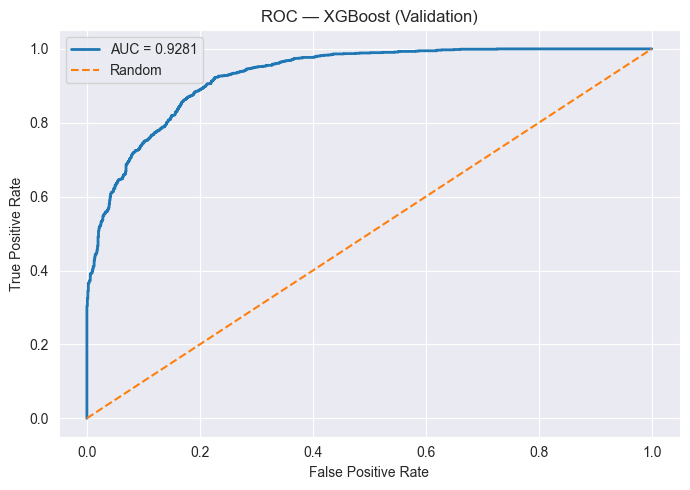

In [15]:
if n_classes==2:
    fpr, tpr, _ = roc_curve(y_va, y_prob)
    auc = roc_auc_score(y_va, y_prob)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", linewidth=2)
    plt.plot([0,1],[0,1],'--', label="Random")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC — XGBoost (Validation)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Multiclass ROC: compute micro/macro as needed.")

## Save Model & Preprocessor

In [16]:
import re, joblib

os.makedirs("models", exist_ok=True)
safe_repo_id = re.sub(r'[^A-Za-z0-9_.-]+', '_', repo_id)

bundle = {
    "preprocessor": preprocessor,   # fitted
    "model": xgb,                   # fitted
    "target_name": TARGET_COLUMN_NAME,
    "label2id": label2id,
    "id2label": id2label,
    "numeric": NUMERIC_FEATURE_NAMES,
    "categorical": CATEGORICAL_FEATURE_NAMES
}

path = f"models/XGB_{safe_repo_id}.joblib"
joblib.dump(bundle, path)
print("Saved:", os.path.abspath(path))

Saved: C:\Users\Owner\PycharmProjects\Adversarial-Attacks-Article\models\models\XGB_yuvalira_adult_income_balanced.joblib
